# Lesson 2 project 2: Higgs decay combinatorics

In [ ]:
import numpy as np
import h5py

dataset_hdf5 = h5py.File("../data/SMHiggsToZZTo4L.h5")

<br><br><br>

This HDF5 file contains the same Higgs data, but as arrays, rather than JSON.

<br>

HDF5 is a file format for arrays, arranged as named objects ("datasets") in directories ("groups").

In [ ]:
dataset_hdf5.keys()

In [ ]:
list(dataset_hdf5.values())

<br><br><br>

In this file,

  * the `events` group contains all of the event-level variables (one scalar per event)
    * run, luminosityBlock, event, PV_x, PV_y, PV_z, MET_pt, MET_phi
  * the `particles` group contains all of the particle-level variables (one scalar per particle)
    * the above, duplicated for each particle
    * pt, phi, eta, mass, pfRelIso03_all, pfRelIso04_all (-1 if electron), dxy, dxyErr, dz, dzErr
    * is_muon is `True` for muons and `False` for electrons
  * the `counts` dataset has the number of particles in each event (one count per event)
  * the `offsets` dataset has a cumulative sum of `counts`

<br><br><br>

In [ ]:
pv_x = np.asarray(dataset_hdf5["events"]["PV_x"])
pv_x

In [ ]:
pv_y = np.asarray(dataset_hdf5["events"]["PV_y"])
pv_y

In [ ]:
pv_z = np.asarray(dataset_hdf5["events"]["PV_z"])
pv_z

<br><br><br>

### Histogramming

NumPy interactions are usually one operation at a time, rather than one data value at a time. We'll need a way to see what happens to _distributions_ in each step, rather than values.

<br>

The **hist** library provides the same kind of interface for histograms.

In [ ]:
import hist

<br>

See the [docs](https://hist.readthedocs.io/en/latest/user-guide/quickstart.html) for how to book and fill histograms.

In [ ]:
hist.Hist.new.Regular(100, -0.5, 0.5).Double().fill(pv_x)

In [ ]:
hist.Hist.new.Regular(100, -0.5, 0.5).Double().fill(pv_y)

In [ ]:
hist.Hist.new.Regular(100, -0.5, 0.5).Double().fill(pv_z)

<br>

Fill a 3-dimensional histogram, and we'll work with the already-aggregated data.

In [ ]:
pv_hist = (
    hist.Hist.new
    .Regular(1000, -0.5, 0.5, name="x")
    .Regular(1000, -0.5, 0.5, name="y")
    .Regular(100, -20.0, 20.0, name="z")
    .Double()
    .fill(x=pv_x, y=pv_y, z=pv_z)
)
pv_hist

<br>

hist has a [slicing syntax](https://uhi.readthedocs.io/en/latest/indexing.html) similar to NumPy arrays, with some extensions.

Plot $x$ versus $y$ by summing over $z$ (see [plotting docs](https://hist.readthedocs.io/en/latest/user-guide/notebooks/Plots.html)):

In [ ]:
pv_hist[:, :, ::sum].plot2d_full();

<br>

That's a tight beamspot; let's zoom in.

In [ ]:
from hist import loc

pv_hist[loc(0.2):loc(0.3), loc(0.3):loc(0.5), ::sum].plot2d_full();

<br>

This cuts around the beamspot in $x$ and $y$ and plots $z$.

In [ ]:
pv_hist[loc(0.2):loc(0.3):sum, loc(0.3):loc(0.5):sum, :].plot();

<br><br><br>

Histograms with many bins or many dimensions use a lot of memory, so it helps to clean up when finished.

In [ ]:
del pv_hist

<br><br><br>

### The problem with particles

We'd like to investigate the particles in the same way.

In [ ]:
hist.Hist.new.Regular(100, 0, 100, name="pt").Double().fill(dataset_hdf5["particles"]["pt"]).plot();

<br>

But are these electrons or muons? Which events are they from?

Answers: all of them, all of them.

<br>

In the previous exercise, the boundaries between events mattered a lot: we had to find all combinations of particles _in each event_.

<br>

In [ ]:
import json

dataset_json = json.load(open("../data/SMHiggsToZZTo4L.json"))

In [ ]:
for event in dataset_json[:5]:
    print(f"new event")
    for electron in event["electron"]:
        print(f"    electron pt {electron['pt']}")
    for muon in event["muon"]:
        print(f"    muon pt {muon['pt']}")

<br>

Knowing the number of particles in each event, we can reconstruct that information.

In [ ]:
counts = np.asarray(dataset_hdf5["counts"])
is_muon = np.asarray(dataset_hdf5["particles"]["is_muon"])
pt = np.asarray(dataset_hdf5["particles"]["pt"])

start = 0
stop = 0
for num_particles in counts[:5]:
    stop += num_particles
    print(f"new event")
    for index in range(start, stop):
        if is_muon[index]:
            print(f"    muon pt {pt[index]}")
        else:
            print(f"    electron pt {pt[index]}")
    start = stop

<br>

But this is not array-oriented programming. We'll see more about this issue in the next lesson.

<br><br><br>

### Analysis with an $ee\mu\mu$ sample

One of the decay modes of Higgs → ZZ is ZZ → 2 electrons + 2 muons.

<br>

<center>
<img src="../img/higgs-to-four-leptons-diagram.png" width="500px">
</center>

<br>

The HDF5 file contains another group with events that have exactly 2 electrons and 2 muons.

In [ ]:
dataset_hdf5["ee_mumu"]["e1"]

In [ ]:
dataset_hdf5["ee_mumu"]["e2"]

In [ ]:
dataset_hdf5["ee_mumu"]["mu1"]

In [ ]:
dataset_hdf5["ee_mumu"]["mu2"]

In [ ]:
list(dataset_hdf5["ee_mumu"]["mu2"].values())

<br>

The datasets in all four of these nested groups correspond to 30868 $ee\mu\mu$ events (drawn from a larger dataset than the JSON).

Index `i` in every array corresponds to the same event `i`.

In [ ]:
dataset_hdf5["ee_mumu"]["e1"]["pt"][0]

In [ ]:
dataset_hdf5["ee_mumu"]["e2"]["pt"][0]

In [ ]:
dataset_hdf5["ee_mumu"]["mu1"]["pt"][0]

In [ ]:
dataset_hdf5["ee_mumu"]["mu2"]["pt"][0]

<br>

From the JSON,

In [ ]:
for event in dataset_json:
    if len(event["electron"]) == 2 and len(event["muon"]) == 2:
        # find the first event with two electrons and two muons, then break out of the loop
        break

print(event["electron"][0]["pt"])
print(event["electron"][1]["pt"])
print(event["muon"][0]["pt"])
print(event["muon"][1]["pt"])

<br><br><br>

### Coordinate transformations

Previously, we used the **vector** library to transform between `pt`, `phi`, `eta` and `px`, `py`, `pz`.

In [ ]:
import vector

In [ ]:
v = vector.obj(
    pt = event["electron"][0]["pt"],
    phi = event["electron"][0]["phi"],
    eta = event["electron"][0]["eta"],
    mass = event["electron"][0]["mass"],
)

In [ ]:
v.px

In [ ]:
v.py

In [ ]:
v.pz

<br>

We can still use the **vector** library because it also performs coordinate transformations on arrays (see [docs](https://vector.readthedocs.io/en/latest/usage/intro.html#NumPy-arrays-of-vectors)).

In [ ]:
e1 = vector.array({
    "pt": dataset_hdf5["ee_mumu"]["e1"]["pt"],
    "phi": dataset_hdf5["ee_mumu"]["e1"]["phi"],
    "eta": dataset_hdf5["ee_mumu"]["e1"]["eta"],
    "mass": dataset_hdf5["ee_mumu"]["e1"]["mass"],
})

In [ ]:
e1.px

In [ ]:
e1.py

In [ ]:
e1.pz

<br>

In [ ]:
e2 = vector.array({
    "pt": dataset_hdf5["ee_mumu"]["e2"]["pt"],
    "phi": dataset_hdf5["ee_mumu"]["e2"]["phi"],
    "eta": dataset_hdf5["ee_mumu"]["e2"]["eta"],
    "mass": dataset_hdf5["ee_mumu"]["e2"]["mass"],
})
mu1 = vector.array({
    "pt": dataset_hdf5["ee_mumu"]["mu1"]["pt"],
    "phi": dataset_hdf5["ee_mumu"]["mu1"]["phi"],
    "eta": dataset_hdf5["ee_mumu"]["mu1"]["eta"],
    "mass": dataset_hdf5["ee_mumu"]["mu1"]["mass"],
})
mu2 = vector.array({
    "pt": dataset_hdf5["ee_mumu"]["mu2"]["pt"],
    "phi": dataset_hdf5["ee_mumu"]["mu2"]["phi"],
    "eta": dataset_hdf5["ee_mumu"]["mu2"]["eta"],
    "mass": dataset_hdf5["ee_mumu"]["mu2"]["mass"],
})

<br>

Mass of the $Z$ boson constructed from $ee$:

In [ ]:
zmass_ee = (e1 + e2).mass
zmass_ee

<br>

Mass of the $Z$ boson constructed from $\mu\mu$:

In [ ]:
zmass_mumu = (mu1 + mu2).mass
zmass_mumu

<br><br><br><br><br>

## Exercise part 1

Plot `zmass_mumu` versus `zmass_ee`. It should look like this (60 bins×60 bins):

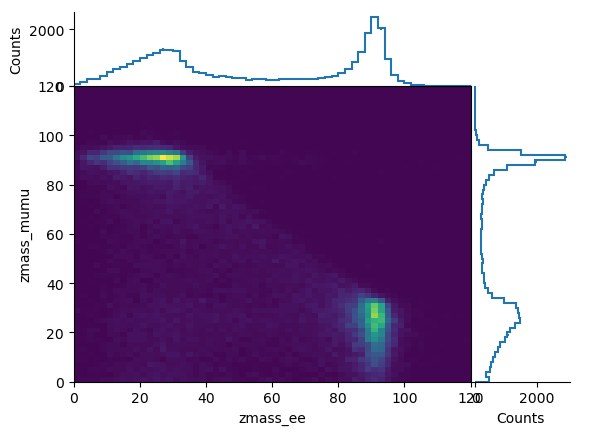

**ANSWER HERE:**

<br><br><br><br><br>

## Exercise part 2

Plot the Higgs mass. It should look like this (100 bins):

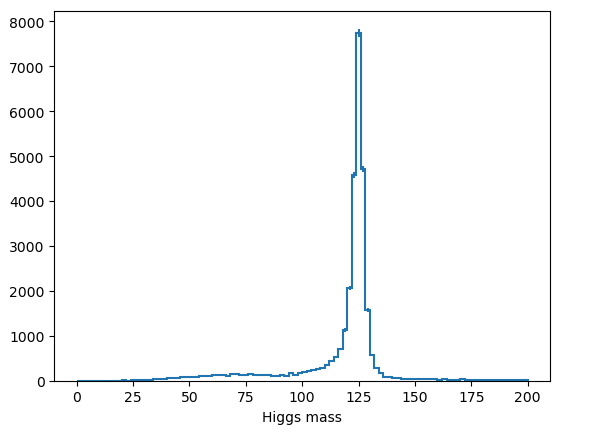

**ANSWER HERE:**

<br><br><br>

### Charge quality cut

In the next part of the exercise, you'll apply quality cuts.

**First quality cut:** The two electrons are $e^+$ and $e^-$ and the two muons are $\mu^+$ and $\mu^-$.

<br>

Get the particle charges as arrays:

In [ ]:
e1_charge = np.asarray(dataset_hdf5["ee_mumu"]["e1"]["charge"])
e2_charge = np.asarray(dataset_hdf5["ee_mumu"]["e2"]["charge"])
mu1_charge = np.asarray(dataset_hdf5["ee_mumu"]["mu1"]["charge"])
mu2_charge = np.asarray(dataset_hdf5["ee_mumu"]["mu2"]["charge"])

<br>

Let's look at the distribution of charges in a 5 bin×5 bin histogram.

In [ ]:
charge_hist = hist.Hist.new.Integer(-2, 3, name="q_ee").Integer(-2, 3, name="q_mumu").Double().fill(
    q_ee=e1_charge + e2_charge,
    q_mumu=mu1_charge + mu2_charge,
)
charge_hist

<br>

Most of the distribution is at `e1_charge + e2_charge == 0` and `mu1_charge + mu2_charge == 0` (high quality Higgs events).

We can ask the histogram for its bin data as an array:

In [ ]:
charge_hist.values()

Why is it distributed like that?

<br>

We can also use Matplotlib to make overlays of cross-sections that do not include the central peak.

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

charge_hist[:, 0].plot(ax=ax1);
charge_hist[:, 4].plot(ax=ax1);
charge_hist[0, :].plot(ax=ax2);
charge_hist[4, :].plot(ax=ax2);

<br>

To select events with `e1_charge + e2_charge == 0` and `mu1_charge + mu2_charge == 0`, we can make each expression into a boolean array,

In [ ]:
e1_charge + e2_charge == 0

and apply it as a slice.

In [ ]:
fix, ax = plt.subplots(1, 1)

hist.Hist.new.Regular(120, 0, 120, name="mass Z_ee").Double().fill(
    zmass_ee
).plot(ax=ax);

hist.Hist.new.Regular(120, 0, 120, name="mass Z_ee").Double().fill(
    zmass_ee[e1_charge + e2_charge == 0]
).plot(ax=ax);

<br>

But how do you apply both?

Unfortunately, you have to use `&` for "and", `|` for "or", `~` for "not".

This is unfortunate because the comparison operation (`==`, `!=`, `<`, `>`, `<=`, `>=`) has to be surrounded by parentheses for the right order of operations.

In [ ]:
fix, ax = plt.subplots(1, 1)

hist.Hist.new.Regular(120, 0, 120, name="mass Z_mumu").Double().fill(
    zmass_mumu
).plot(ax=ax);

hist.Hist.new.Regular(120, 0, 120, name="mass Z_mumu").Double().fill(
    zmass_mumu[e1_charge + e2_charge == 0]
).plot(ax=ax);

hist.Hist.new.Regular(120, 0, 120, name="mass Z_mumu").Double().fill(
    zmass_mumu[(e1_charge + e2_charge == 0) & (mu1_charge + mu2_charge == 0)]
).plot(ax=ax);

<br><br><br><br><br>

## Exercise part 3

Since most of the data would pass the charge cut, the difference that it makes to the final Higgs mass plot is barely perceptible. Instead, draw the Higgs mass with only those events that _fail_ the charge quality cut.

It should look like this (100 bins):

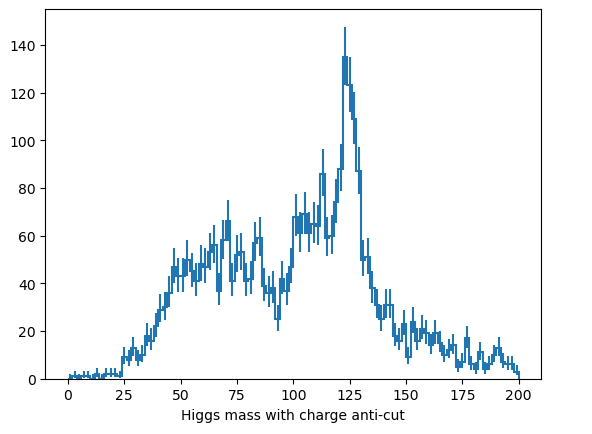

**ANSWER HERE:**

<br><br><br>

### Z mass quality cut

**Second quality cut:**

  * 12 GeV/$c^2$ < smallest Z mass < 120 GeV/$c^2$
  * 40 GeV/$c^2$ < largest Z mass < 120 GeV/$c^2$

Now that you have

In [ ]:
zmass_ee

In [ ]:
zmass_mumu

it would be relatively straightforward to apply selections to the $Z \to ee$ and $Z \to \mu\mu$, but we need to apply selections to `zmass_small` and `zmass_big`.

<br><br><br><br><br>

## Exercise part 4

Define `zmass_small` and `zmass_big` and plot them. There are several ways to do that.

It should look like this (60 bins×60 bins):

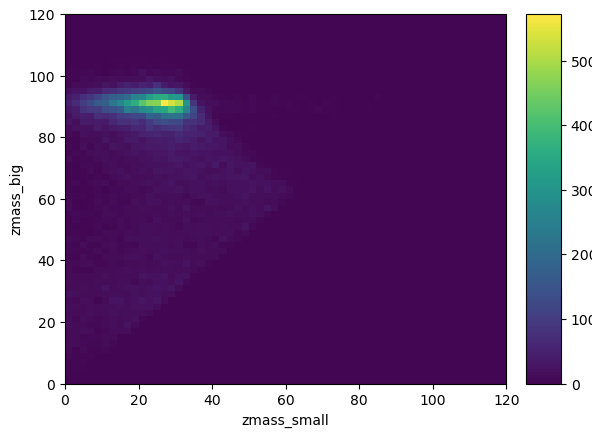

**ANSWER HERE:**

<details>
    <summary><b>Hint 1...</b></summary>

<br>

You could use [np.where](https://numpy.org/doc/stable/reference/generated/numpy.where.html).

</details>

<br>

<details>
    <summary><b>Hint 2...</b></summary>

<br>

You could also define `zmass_small` and `zmass_big` as empty arrays and fill them like:

```python
zmass_small[zmass_ee < zmass_mumu] = zmass_ee
zmass_small[zmass_mumu < zmass_ee] = zmass_mumu
```

</details>

<br><br><br><br><br>

## Exercise part 5

Make a final Higgs plot with and without the Z mass quality cut. It should look like this (100 bins):

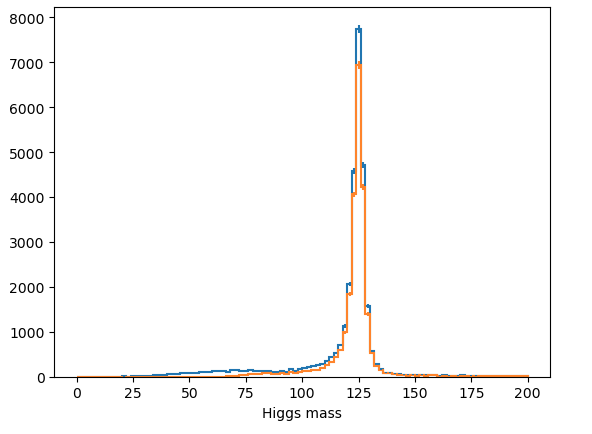

**ANSWER HERE:**

<br><br><br><br><br>

For fun, you can also make the anti-cut plot. It should look like this (100 bins):

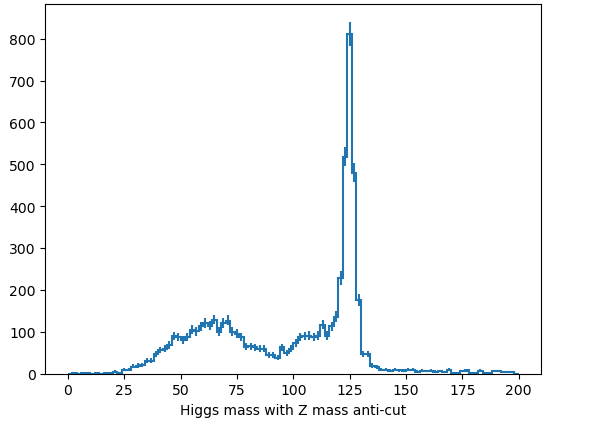

**ANSWER HERE:**